In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import os
import json
import mat73
import fooof
import mne
import specparam
import pickle
from fooof import FOOOF
from mne.time_frequency import tfr_array_multitaper, tfr_array_morlet
import neurodsp
from neurodsp.filt import filter_signal
from neurodsp.plts import plot_time_series
from neurodsp.sim import sim_combined
from neurodsp.spectral import compute_spectrum
from bycycle import Bycycle
from bycycle.cyclepoints import find_extrema, find_zerox
from bycycle.cyclepoints.zerox import find_flank_zerox
from bycycle.plts import plot_cyclepoints_array
from bycycle.utils.download import load_bycycle_data
from bycycle import BycycleGroup
from bycycle.plts.features import plot_feature_hist


C:\Users\Kriza\AppData\Local\Temp\ipykernel_16408\2449345789.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  import fooof


In [2]:
"""
Auxillary function used within the maxInterval function
"""
def spikes_to_df(filepath, well_row, well_col, channel_row, channel_col):
    """
    Function:
        Convert Plate.mat file to dictionary and 
        isolate a single channel from a single well within the plate
    Returns:
        DataFrame with single column ('Time (s)') contiaing channel spike times
    """
    data_dict = mat73.loadmat(filepath)
    well=data_dict['Plate'][well_row][well_col]
    channel=well[channel_row][channel_col]
    if type(channel)==np.ndarray:
        pass
    else:
        channel=np.array([])
        print(f'...NoneType value detected at channel {channel_row, channel_col}!!!... converted to empty array')

            
    return pd.DataFrame({'Time (s)': channel})

In [3]:
def maxInterval(spiketrain, max_begin_ISI=0.17, max_end_ISI=0.3, min_IBI=0.2, min_burst_duration=0.01,
                min_spikes_in_burst=5):
    allBurstData = {}

    '''
    Phase 1 - Burst Detection
    Here a burst is defined as starting when two consecutive spikes have an
    ISI less than max_begin_ISI apart. The end of the burst is given when two
    spikes have an ISI greater than max_end_ISI.
    Find ISIs closer than max_begin_ISI and end with max_end_ISI.
    The last spike of the previous burst will be used to calculate the IBI.
    For the first burst, there is no previous IBI.
    '''
    inBurst = False
    burstNum = 0
    currentBurst = []
    for n in range(1, len(spiketrain)):
        ISI = spiketrain[n] - spiketrain[n - 1]
        if inBurst:
            if ISI > max_end_ISI:  # end the burst
                currentBurst = np.append(currentBurst, spiketrain[n - 1])
                allBurstData[burstNum] = currentBurst
                currentBurst = []
                burstNum += 1
                inBurst = False
            elif (ISI < max_end_ISI) & (n == len(spiketrain) - 1):
                currentBurst = np.append(currentBurst, spiketrain[n])
                allBurstData[burstNum] = currentBurst
                burstNum += 1
            else:
                currentBurst = np.append(currentBurst, spiketrain[n - 1])
        else:
            if ISI < max_begin_ISI:
                currentBurst = np.append(currentBurst, spiketrain[n - 1])
                inBurst = True
    # Calculate IBIs
    IBI = []
    for b in range(1, burstNum):
        prevBurstEnd = allBurstData[b - 1][-1]
        currBurstBeg = allBurstData[b][0]
        IBI = np.append(IBI, (currBurstBeg - prevBurstEnd))

    '''
    Phase 2 - Merging of Bursts
    Here we see if any pair of bursts have an IBI less than min_IBI; if so,
    we then merge the bursts. We specifically need to check when say three
    bursts are merged into one.
    '''
    tmp = allBurstData
    allBurstData = {}
    burstNum = 0
    for b in range(1, len(tmp)):
        prevBurst = tmp[b - 1]
        currBurst = tmp[b]
        if IBI[b - 1] < min_IBI:
            prevBurst = np.append(prevBurst, currBurst)
        allBurstData[burstNum] = prevBurst
        burstNum += 1
    if burstNum >= 2:
        allBurstData[burstNum] = currBurst

    '''
    Phase 3 - Quality Control
    Remove small bursts less than min_bursts_duration or having too few
    spikes less than min_spikes_in_bursts. In this phase we have the
    possibility of deleting all spikes.
    '''
    tooShort = 0
    tmp = allBurstData
    allBurstData = {}
    burstNum = 0
    if len(tmp) > 1:
        for b in range(len(tmp)):
            currBurst = tmp[b]
            if len(currBurst) <= min_spikes_in_burst:
                tooShort +=1
            elif currBurst[-1] - currBurst[0] <= min_burst_duration:
                tooShort += 1
            else:
                allBurstData[burstNum] = currBurst
                burstNum += 1

    return allBurstData, tooShort

In [4]:
def burst_plotting(filename, well_row, well_column, plot_spk=False, plot_brst=False):
    
    # imports
    from scipy import io
    import numpy as np
    import pandas as pd
    import mat73
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import normalize

    # load .mat file
    data_dict = mat73.loadmat(filename)

    # aggregate all spikes across all channels
    well=data_dict['Plate'][well_row][well_column]
    all_spikes=np.array([])
    ch_spks={}
    raster_position=0
    for i in range(4):
        for j in range(4):
            if type(well[i][j])==np.ndarray:
                pass
            else:
                well[i][j]=np.array([])
                print(f'...NoneType value detected at channel {i,j}!!!... converted to empty array')
            all_spikes=np.append(all_spikes, well[i][j])
            ch_spks[raster_position]=well[i][j]
            raster_position+=1
    

    #      ------------------------------------------
    #   ------------     VISUALIZATIONS     ------------          
    #      ------------------------------------------

    if plot_spk==True or plot_brst==True:
        fig, (ax_hist, ax_raster) = plt.subplots(2, 1, figsize=(15, 8), gridspec_kw={'height_ratios': [1, 2]}, sharex=True)


    # Raster plots
    well_bursts=np.array([])
    raster_position=0
    for i in range(4):
        for j in range(4):
            print(f'Row {i} Col {j} Channel')
            spike_times = well[i][j]
            if spike_times.ndim==0:
                spike_times=np.array([spike_times])

    


            channel_df=pd.DataFrame({'Time (s)': spike_times})
            allBurstData, _ = maxInterval(channel_df["Time (s)"].values)
            well_bursts=np.append(well_bursts, allBurstData)
            if plot_brst==True:
                for b in allBurstData:
                    burst_start = allBurstData[b][0]
                    burst_duration = allBurstData[b][-1]-burst_start
                    raster_rect = Rectangle((burst_start, raster_position + 0.5), burst_duration, 1, alpha=0.5, edgecolor='turquoise', facecolor='turquoise')
                    hist_rect = Rectangle((burst_start, 0), burst_duration, .11, alpha=0.075, edgecolor='turquoise', facecolor='turquoise')
                    ax_raster.add_patch(raster_rect)
                    ax_hist.add_patch(hist_rect)
            if plot_spk==True:
                # Plot each spike time as a vertical line
                ax_raster.vlines(spike_times, raster_position + 0.55, raster_position + 1.45, linewidth=0.4, color='black', alpha=.4)
            raster_position+=1
    
    if plot_spk==True:
        # Histogram plot
        ax_hist.hist(all_spikes, bins=1200, density=True, color='black')
        ax_hist.set_ylabel('Frequency')
        ax_hist.set_title(f'Spike Data Summary (well[{well_row},{well_column}])')
        # ax_hist.set_xlim()

        ax_raster.set_yticks(range(1, 17))
        ax_raster.set_ylabel('Channels')
        ax_raster.set_xlabel('Time (s)')
        # ax_raster.set_xlim(0,38)
        
        # Adjust layout
        plt.subplots_adjust(hspace=0.1)
        plt.show()

    return list(ch_spks.values()), well_bursts, all_spikes

In [5]:
def process_plate_data(filename, wells, condition):
    results = {}
    for row in range(6):  # 6 rows
        for col in range(8):  # 8 columns
            well_number = f"{row}{col if col < 8 else col+2}"
            well_name = f"well{well_number}_{condition}"
            print(f"Processing {well_name}")
            spikes, bursts, all_spikes = burst_plotting(filename, row, col, False, False)
            results[well_name] = {
                "spikes": spikes,
                "bursts": bursts,
                "all_spikes": all_spikes
            }
    return results

def save_results(results, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    for well_name, data in results.items():
        file_path = os.path.join(folder_name, f"{well_name}.json")
        with open(file_path, 'w') as f:
            json.dump(data, f, cls=NumpyEncoder)

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

# Define the files to process
files = {
    "baseline": "PlatesData/SP1_20180712_20180803_baseline_output.mat",
    "5min": "PlatesData/SP1_20180712_20180803_5min_output.mat",
    "60min": "PlatesData/SP1_20180712_20180803_60min_output.mat",
    "24h_postwashing": "PlatesData/SP1_20180712_20180804_24h_postwashing_output.mat"
}

# Process all data
all_results = {}
for condition, filename in files.items():
    print(f"\nProcessing {condition} condition")
    condition_results = process_plate_data(filename, None, condition)
    all_results.update(condition_results)
    print(f"Number of wells for {condition}: {len(condition_results)}")
    
    # Create folder name based on the .mat file name
    folder_name = os.path.splitext(os.path.basename(filename))[0]
    
    # Save results for this condition
    save_results(condition_results, folder_name)




Processing baseline condition
Processing well00_baseline
Row 0 Col 0 Channel
Row 0 Col 1 Channel
Row 0 Col 2 Channel
Row 0 Col 3 Channel
Row 1 Col 0 Channel
Row 1 Col 1 Channel
Row 1 Col 2 Channel
Row 1 Col 3 Channel
Row 2 Col 0 Channel
Row 2 Col 1 Channel
Row 2 Col 2 Channel
Row 2 Col 3 Channel
Row 3 Col 0 Channel
Row 3 Col 1 Channel
Row 3 Col 2 Channel
Row 3 Col 3 Channel
Processing well01_baseline
Row 0 Col 0 Channel
Row 0 Col 1 Channel
Row 0 Col 2 Channel
Row 0 Col 3 Channel
Row 1 Col 0 Channel
Row 1 Col 1 Channel
Row 1 Col 2 Channel
Row 1 Col 3 Channel
Row 2 Col 0 Channel
Row 2 Col 1 Channel
Row 2 Col 2 Channel
Row 2 Col 3 Channel
Row 3 Col 0 Channel
Row 3 Col 1 Channel
Row 3 Col 2 Channel
Row 3 Col 3 Channel
Processing well02_baseline
Row 0 Col 0 Channel
Row 0 Col 1 Channel
Row 0 Col 2 Channel
Row 0 Col 3 Channel
Row 1 Col 0 Channel
Row 1 Col 1 Channel
Row 1 Col 2 Channel
Row 1 Col 3 Channel
Row 2 Col 0 Channel
Row 2 Col 1 Channel
Row 2 Col 2 Channel
Row 2 Col 3 Channel
Row 3 Co

Row 0 Col 0 Channel
Row 0 Col 1 Channel
Row 0 Col 2 Channel
Row 0 Col 3 Channel
Row 1 Col 0 Channel
Row 1 Col 1 Channel
Row 1 Col 2 Channel
Row 1 Col 3 Channel
Row 2 Col 0 Channel
Row 2 Col 1 Channel
Row 2 Col 2 Channel
Row 2 Col 3 Channel
Row 3 Col 0 Channel
Row 3 Col 1 Channel
Row 3 Col 2 Channel
Row 3 Col 3 Channel


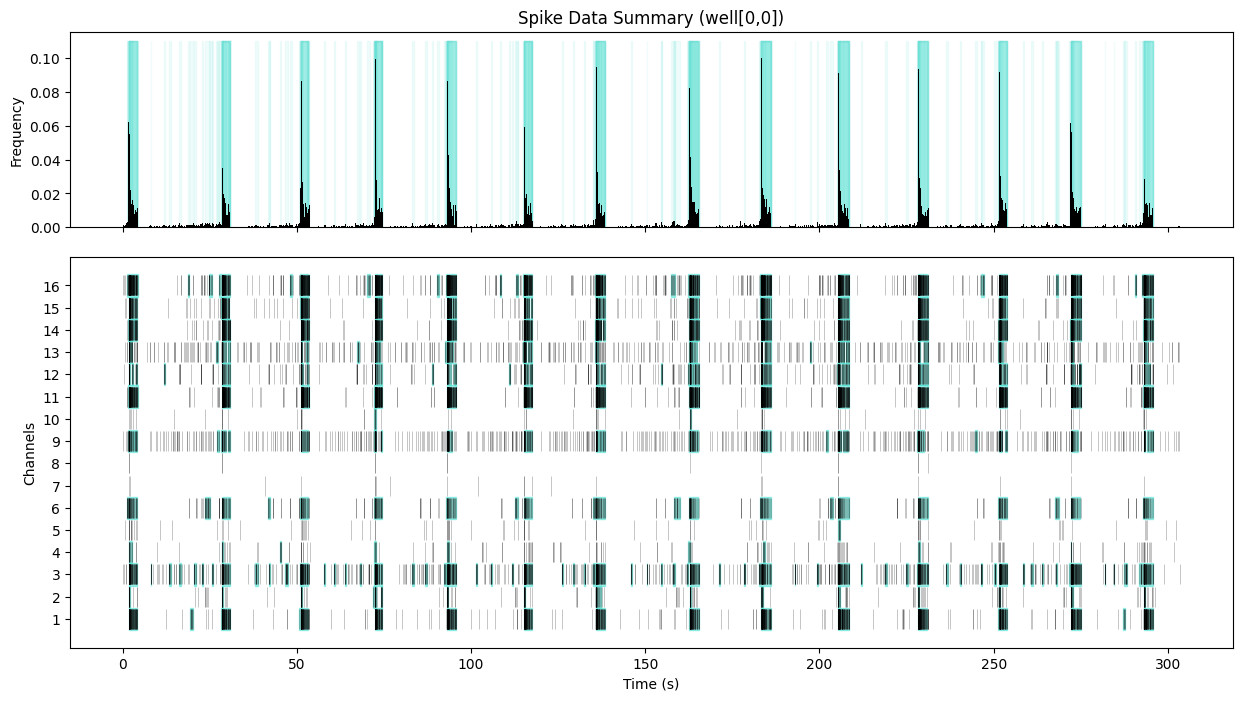

Row 0 Col 0 Channel
Row 0 Col 1 Channel
Row 0 Col 2 Channel
Row 0 Col 3 Channel
Row 1 Col 0 Channel
Row 1 Col 1 Channel
Row 1 Col 2 Channel
Row 1 Col 3 Channel
Row 2 Col 0 Channel
Row 2 Col 1 Channel
Row 2 Col 2 Channel
Row 2 Col 3 Channel
Row 3 Col 0 Channel
Row 3 Col 1 Channel
Row 3 Col 2 Channel
Row 3 Col 3 Channel


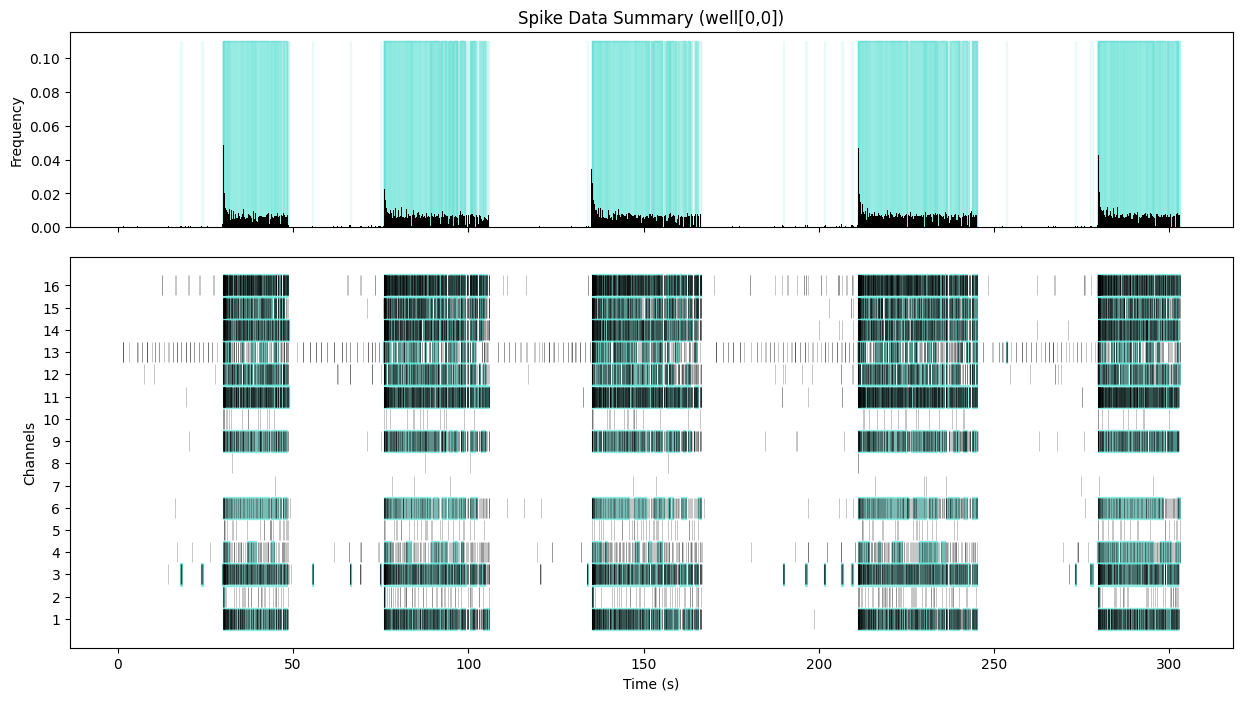

302.91464


In [6]:
well25_bl, _, all_spikes_bl =burst_plotting('PlatesData/SP1_20180712_20180803_baseline_output.mat', 0, 0, plot_spk=True, plot_brst=True)
well25_5m, _, all_spikes_5m = burst_plotting('PlatesData/SP1_20180712_20180803_5min_output.mat', 0, 0, plot_spk=True, plot_brst=True)

max_time = np.max(all_spikes_5m)
print(max_time)

In [5]:

def double_exponential_kernel(t, tau_rise=2, tau_decay=25):
    """Create a double exponential kernel for glutamatergic neurons."""
    # This function models the synaptic response of glutamatergic neurons
    # t: time
    # tau_rise: rise time constant
    # tau_decay: decay time constant
    return (1.0 - np.exp(-t/tau_rise)) * np.exp(-t/tau_decay)

def process_spikes_with_kernel(all_spikes, bin_size_ms, kernel_window=200, tau_rise=2, tau_decay=25):
    """Process spike data with double exponential kernel and return smoothed data."""
    # Find the maximum spike time (already in seconds)
    max_time = np.max(all_spikes)
    
    # Calculate number of bins
    # Convert max_time to milliseconds to match bin_size_ms
    num_bins = int(np.ceil((max_time * 1000) / bin_size_ms))
    
    # Create bins in seconds to match the original spike times
    bins = np.linspace(0, max_time, num_bins + 1)
   
    # Create histogram of spike times
    hist, bin_edges = np.histogram(all_spikes, bins=bins, density=True)
   
    # Create and apply the double exponential kernel
    # kernel_window is in milliseconds, so we convert it to seconds
    t = np.linspace(0, kernel_window/1000, num=kernel_window)
    kernel = double_exponential_kernel(t, tau_rise, tau_decay)
    kernel = kernel / np.sum(kernel)  # Normalize the kernel

    # Convolve histogram with kernel for smoothing
    smoothed = np.convolve(hist, kernel, mode='same')
   
    return bin_edges[:-1], smoothed

def compute_tfr(lfp_2d, fs, freqs, freq_spacing='lin', time_window_length=1,
                freq_bandwidth=2, n_jobs=-1, decim=1, output='power',
                method='multitaper', n_morlet_cycle=7, verbose=False):
    """Compute time-frequency representation (TFR) of LFP data."""
    """Adapted from MJ code"""
    # Prepare LFP data for TFR computation (we need to add dimension since it's a single "channel")
    lfp_3d = lfp_2d[np.newaxis, :, :]
    
    # Generate frequency array based on specified spacing
    if freq_spacing == 'lin':
        freq = np.linspace(*freqs)
    elif freq_spacing == 'log':
        freq = np.logspace(*np.log10(freqs[:2]), freqs[2])
    
    # Calculate number of cycles for each frequency
    n_cycles = freq * time_window_length
    time_bandwidth = min(time_window_length * freq_bandwidth, 4)  # Limit time-bandwidth product for low frequencies

    # Compute TFR using either multitaper or Morlet wavelet method
    if method == 'multitaper':
        tfr = tfr_array_multitaper(lfp_3d, sfreq=fs, freqs=freq, n_cycles=n_cycles,
                                    time_bandwidth=time_bandwidth,
                                    output=output, n_jobs=n_jobs, decim=decim, verbose=verbose)
    elif method == 'morlet':
        tfr = tfr_array_morlet(lfp_3d, sfreq=fs, freqs=freq, n_cycles=n_morlet_cycle,
                               output=output, n_jobs=n_jobs, decim=decim,
                               verbose=verbose)
    tfr = tfr[0]
    return tfr, freq


In [12]:
def analyze_power_spectrum_with_fooof(power_spectrum, freqs, freq_range=[0.1, 12]):
    """Analyze power spectrum using FOOOF, optimized for low frequencies in long recordings."""
    # Initialize FOOOF model with parameters optimized for low frequencies
    fm = FOOOF(
        peak_width_limits=[.5, 8],  # Adjusted to allow for narrower and wider low-frequency peaks
        min_peak_height=0.6,        # Lowered to potentially catch smaller peaks
        max_n_peaks=6,               # Increased to potentially catch more peaks
        peak_threshold=2,
        aperiodic_mode='fixed'
    )
    
    # Fit FOOOF model to the spectrum
    fm.fit(freqs, power_spectrum, freq_range)
    return fm

def process_well_data(well_data, bin_size_ms=10):
    """Process data for a single well, optimized for low-frequency oscillations"""
    # Extract spike times and process them
    all_spikes = np.array(well_data['all_spikes'])
    bin_edges, smoothed = process_spikes_with_kernel(all_spikes, bin_size_ms)
    
    # Calculate the new sampling rate based on bin_size_ms
    new_fs = 1000 / bin_size_ms  # should be 200 if bin_size_ms=5
    
    # Compute power spectrum using compute_spectrum
    fxx, pxx = compute_spectrum(smoothed, new_fs, avg_type='mean', nperseg=new_fs*60)
    
    # Analyze power spectrum using FOOOF
    fm = analyze_power_spectrum_with_fooof(pxx, fxx, freq_range=[0.1, 12])
    
    # Return processed data and analysis results
    return {
        'bin_edges': bin_edges.tolist(),
        'smoothed': smoothed.tolist(),
        'frequencies': fxx.tolist(),
        'power_spectrum': pxx.tolist(),
        'fm': fm,
        'new_fs': new_fs,
        'orig_fs': 12500  # Include the original sampling rate
    }

In [13]:
def process_folder(input_folder, output_folder):
    """Process all JSON files in the input folder and save results in the output folder."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.json'):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace('.json', '_processed.pkl'))
            
            with open(input_path, 'r') as f:
                well_data = json.load(f)
            
            processed_data = process_well_data(well_data)
            
            with open(output_path, 'wb') as f:
                pickle.dump(processed_data, f)
            
            print(f"Processed {filename} and saved results to {output_path}")

# Define the folders to process
input_folders = [
    "SP1_20180712_20180803_baseline_output",
    "SP1_20180712_20180803_5min_output",
    "SP1_20180712_20180803_60min_output",
    "SP1_20180712_20180804_24h_postwashing_output"
]

# Process each folder
for folder in input_folders:
    input_folder = folder
    output_folder = folder + "_processed"
    print(f"\nProcessing folder: {input_folder}")
    process_folder(input_folder, output_folder)

print("\nAll processing completed.")


Processing folder: SP1_20180712_20180803_baseline_output
Processed well00_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well00_baseline_processed.pkl
Processed well01_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well01_baseline_processed.pkl
Processed well02_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well02_baseline_processed.pkl
Processed well03_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well03_baseline_processed.pkl
Processed well04_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well04_baseline_processed.pkl
Processed well05_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well05_baseline_processed.pkl
Processed well06_baseline.json and saved results to SP1_20180712_20180803_baseline_output_processed\well06_baseline_processed.pkl
Processed well07_baseline.json a

In [14]:
def plot_spikes_with_kernel_and_spectrum(bin_edges, smoothed, frequencies, power_spectrum, fm, bin_size_ms, kernel_window, tau_rise, tau_decay):
    """Plot processed spike data, power spectrum, and FOOOF analysis."""
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))
   
    # Plot smoothed spike rate
    ax1.plot(bin_edges, smoothed, color='blue', linewidth=1.5)
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Smoothed Spike Rate')
    ax1.set_title(f'Bin size: {bin_size_ms} ms, Kernel: {kernel_window} ms\nτ_rise: {tau_rise} ms, τ_decay: {tau_decay} ms')
   
    # Plot power spectrum
    ax2.loglog(frequencies, power_spectrum, color='black', alpha=0.7)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power')
    ax2.set_title('Power Spectrum')
   
    # Plot FOOOF results
    fm.plot(ax=ax3, add_legend=True)
    ax3.set_title('Power Spectrum and FOOOF Model Fit')
    # Add FOOOF parameters as text annotations
    text_y = 0.25
    ax3.text(0.02, text_y, f"Offset: {fm.aperiodic_params_[0]:.2f}", transform=ax3.transAxes, fontsize=12)
    ax3.text(0.02, text_y-0.05, f"Exponent: {fm.aperiodic_params_[1]:.2f}", transform=ax3.transAxes, fontsize=12)
    ax3.text(0.02, text_y-0.10, f"R-squared: {fm.r_squared_:.4f}", transform=ax3.transAxes, fontsize=12)
   
    for i, peak in enumerate(fm.peak_params_):
        ax3.text(0.02, text_y-0.15-i*0.05, f"Peak {i+1}: CF={peak[0]:.2f}, PW={peak[1]:.2f}, BW={peak[2]:.2f}", transform=ax3.transAxes, fontsize=12)
   
    plt.tight_layout()
    return fig, (ax1, ax2, ax3)



def process_and_plot_folder(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for filename in os.listdir(input_folder):
        if filename.endswith('.pkl'):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace('.pkl', '_plots.png'))
            print(output_path)
            with open(input_path, 'rb') as f:
                 processed_data = pickle.load(f)
            
            # Extract data for plotting
            bin_edges = np.array(processed_data['bin_edges'])
            smoothed = np.array(processed_data['smoothed'])
            frequencies = np.array(processed_data['frequencies'])
            power_spectrum = np.array(processed_data['power_spectrum'])
            fm = processed_data['fm']
            new_fs = processed_data['new_fs']
            
            # Some parameters to try (you may want to adjust these or extract from processed_data)
            bin_size_ms = 10 # Assuming this is the default in process_well_data
            kernel_window = 200  # Assuming this is the default in process_spikes_with_kernel
            tau_rise = 2  # Assuming this is the default in process_spikes_with_kernel
            tau_decay = 2
            
         # Assuming this is the default in process_spikes_with_kernel
            
            # Create plots
            fig, _ = plot_spikes_with_kernel_and_spectrum(
                bin_edges, smoothed, frequencies, power_spectrum, fm,
                bin_size_ms, kernel_window, tau_rise, tau_decay
            )
            
            plt.savefig(output_path)
            plt.close(fig)
            
            print(f"Processed and plotted {filename}")

# Usage
input_folders = [
    "SP1_20180712_20180803_baseline_output_processed",
    "SP1_20180712_20180803_5min_output_processed",
    "SP1_20180712_20180803_60min_output_processed",
    "SP1_20180712_20180804_24h_postwashing_output_processed"
]

for folder in input_folders:
    input_folder = folder
    output_folder = folder + "_plots"
    print(f"\nProcessing and plotting folder: {input_folder}")
    process_and_plot_folder(input_folder, output_folder)

print("\nAll processing and plotting completed.")


Processing and plotting folder: SP1_20180712_20180803_baseline_output_processed
SP1_20180712_20180803_baseline_output_processed_plots\well00_baseline_processed_plots.png
Processed and plotted well00_baseline_processed.pkl
SP1_20180712_20180803_baseline_output_processed_plots\well01_baseline_processed_plots.png
Processed and plotted well01_baseline_processed.pkl
SP1_20180712_20180803_baseline_output_processed_plots\well02_baseline_processed_plots.png
Processed and plotted well02_baseline_processed.pkl
SP1_20180712_20180803_baseline_output_processed_plots\well03_baseline_processed_plots.png
Processed and plotted well03_baseline_processed.pkl
SP1_20180712_20180803_baseline_output_processed_plots\well04_baseline_processed_plots.png
Processed and plotted well04_baseline_processed.pkl
SP1_20180712_20180803_baseline_output_processed_plots\well05_baseline_processed_plots.png
Processed and plotted well05_baseline_processed.pkl
SP1_20180712_20180803_baseline_output_processed_plots\well06_baseli

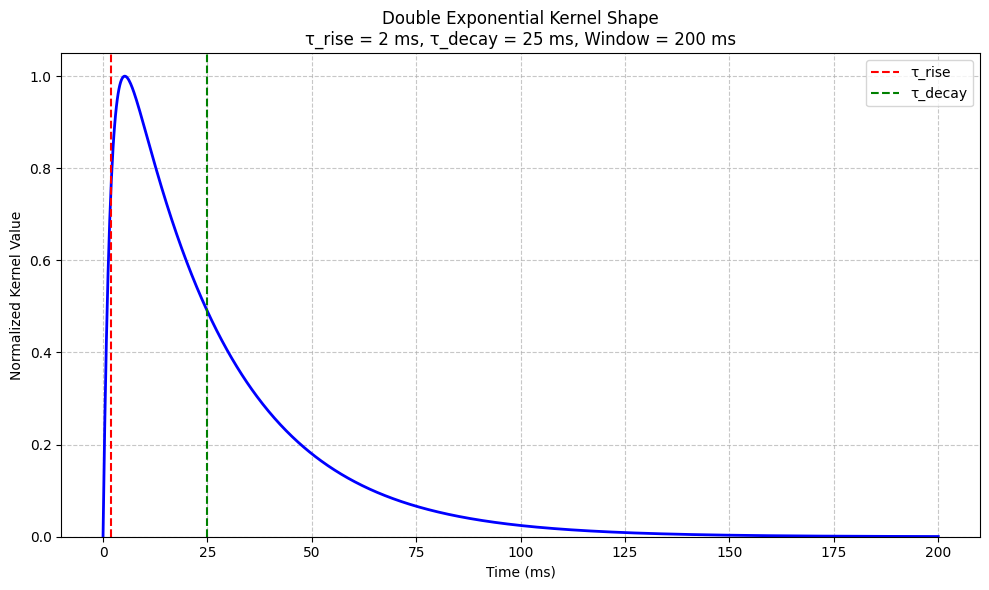

In [11]:
def plot_kernel_shape(kernel_window=150, tau_rise=2, tau_decay=25):
    """Plot the shape of the double exponential kernel."""
    # Create a high-resolution time array (in milliseconds)
    t = np.linspace(0, kernel_window, num=1000)
    
    # Calculate the kernel values
    # Time constants are converted to seconds
    kernel = double_exponential_kernel(t/1000, tau_rise/1000, tau_decay/1000)
    
    # Normalize the kernel to peak at 1
    kernel = kernel / np.max(kernel)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(t, kernel, 'b-', linewidth=2)
    
    # Set labels and title
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Normalized Kernel Value')
    ax.set_title(f'Double Exponential Kernel Shape\n'
                 f'τ_rise = {tau_rise} ms, τ_decay = {tau_decay} ms, Window = {kernel_window} ms')
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Rise and decay time constants
    ax.axvline(x=tau_rise, color='r', linestyle='--', label='τ_rise')
    ax.axvline(x=tau_decay, color='g', linestyle='--', label='τ_decay')
    ax.set_ylim(bottom=0)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Call it
plot_kernel_shape(kernel_window=200, tau_rise=2, tau_decay=25)

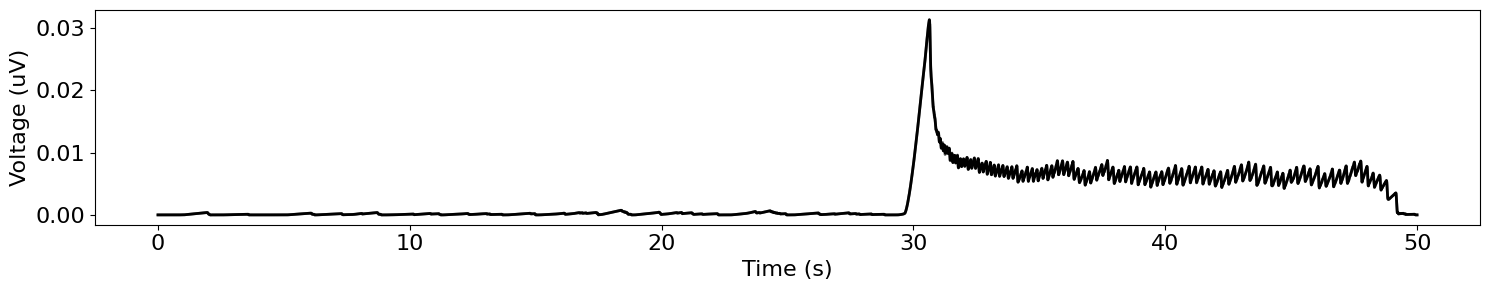

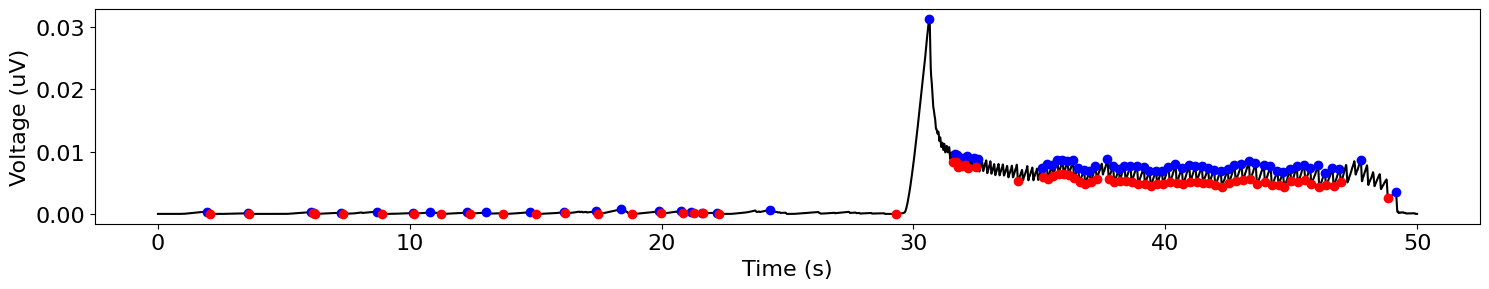

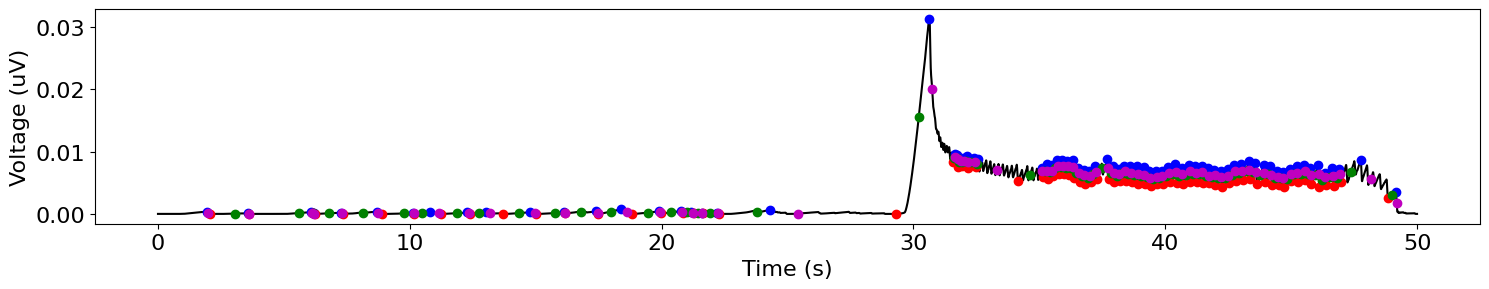

In [25]:
# Bycycle analysis example

# Load processed data from pickle file
input_path = 'SP1_20180712_20180803_5min_output_processed/well00_5min_processed.pkl'
with open(input_path, 'rb') as f:
    processed_data = pickle.load(f)

# Set pandas to display more columns
pd.options.display.max_columns = 10

# Extract smoothed signal and new sampling rate from processed data
sig = np.array(processed_data['smoothed'])
fs = processed_data['new_fs']

# Define filter settings
f_range = (.1, 12)  # Theta band frequency range
f_lowpass = 20  # Lowpass filter cutoff frequency
n_seconds_filter = 40  # Duration for filter in seconds

# Apply lowpass filter to the signal
sig_low = filter_signal(sig, fs, 'lowpass', f_lowpass,
                        n_seconds=n_seconds_filter, remove_edges=False)

# Create time array for plotting
times = np.arange(0, len(sig)/fs, 1/fs)
xlim = (0, 50)  # Set x-axis limits for plotting
tidx = np.logical_and(times >= xlim[0], times < xlim[1])  # Create boolean index for time range

# Plot original and lowpass filtered signals
plot_time_series(times[tidx], [sig[tidx], sig_low[tidx]], colors=['k', 'k'], alpha=[.5, 1], lw=2)

# Apply narrowband filter (theta band)
n_seconds_theta = 20
sig_narrow = filter_signal(sig, fs, 'bandpass', f_range,
                           n_seconds=n_seconds_theta, remove_edges=False)

# Find rising and falling zero-crossings in the narrowband filtered signal
rise_xs = find_flank_zerox(sig_narrow, 'rise')
decay_xs = find_flank_zerox(sig_narrow, 'decay')

# Find peaks and troughs in the lowpass filtered signal
peaks, troughs = find_extrema(sig_low, fs, f_range,
                              filter_kwargs={'n_seconds':n_seconds_theta})

# Plot cycle points (peaks and troughs) on the lowpass filtered signal
plot_cyclepoints_array(sig_low, fs, peaks=peaks, troughs=troughs, xlim=xlim)

# Find rising and falling zero-crossings between peaks and troughs
rises, decays = find_zerox(sig_low, peaks, troughs)

# Plot all cycle points (peaks, troughs, rising and falling zero-crossings) on the lowpass filtered signal
plot_cyclepoints_array(sig_low, fs, xlim=xlim, peaks=peaks, troughs=troughs,
                       rises=rises, decays=decays)

In [26]:
# Burst parameters
thresholds = {
    'amp_fraction': .8,
    'amp_consistency': .5,
    'period_consistency': .3,
    'monotonicity': .7,
    'min_n_cycles': 3
}
#C:\Users\Kriza\anaconda3\envs\team_ndd\Lib\site-packages\bycycle\plts

In [27]:
# Plot bycycle feature distributions

# Load baseline condition data
input_path = 'SP1_20180712_20180803_baseline_output_processed/well00_baseline_processed.pkl'
with open(input_path, 'rb') as f:
    processed_data = pickle.load(f)

# Extract smoothed signal for baseline condition
sig_baseline = np.array(processed_data['smoothed'])

# Load experimental condition data
input_path = 'SP1_20180712_20180803_5min_output_processed/well00_5min_processed.pkl'
with open(input_path, 'rb') as f:
    processed_data = pickle.load(f)

# Extract smoothed signal for 5-minute condition
sig_5m = np.array(processed_data['smoothed'])

# Extract sampling rate (assumed to be the same for both conditions)
fs = processed_data['new_fs']

# Define filter settings
f_lowpass = 20  # Lowpass filter cutoff frequency (Hz)
n_seconds_filter = 40  # Duration for filter in seconds

# Apply lowpass filter to 5-minute condition signal
filt_5m = filter_signal(sig_5m, fs, 'lowpass', f_lowpass,
                        n_seconds=n_seconds_filter, remove_edges=False)

# Apply lowpass filter to baseline condition signal
filt_base = filter_signal(sig_baseline, fs, 'lowpass', f_lowpass,
                          n_seconds=n_seconds_filter, remove_edges=False)

# Note: The code stops here without plotting. Additional code would be needed to plot feature distributions.

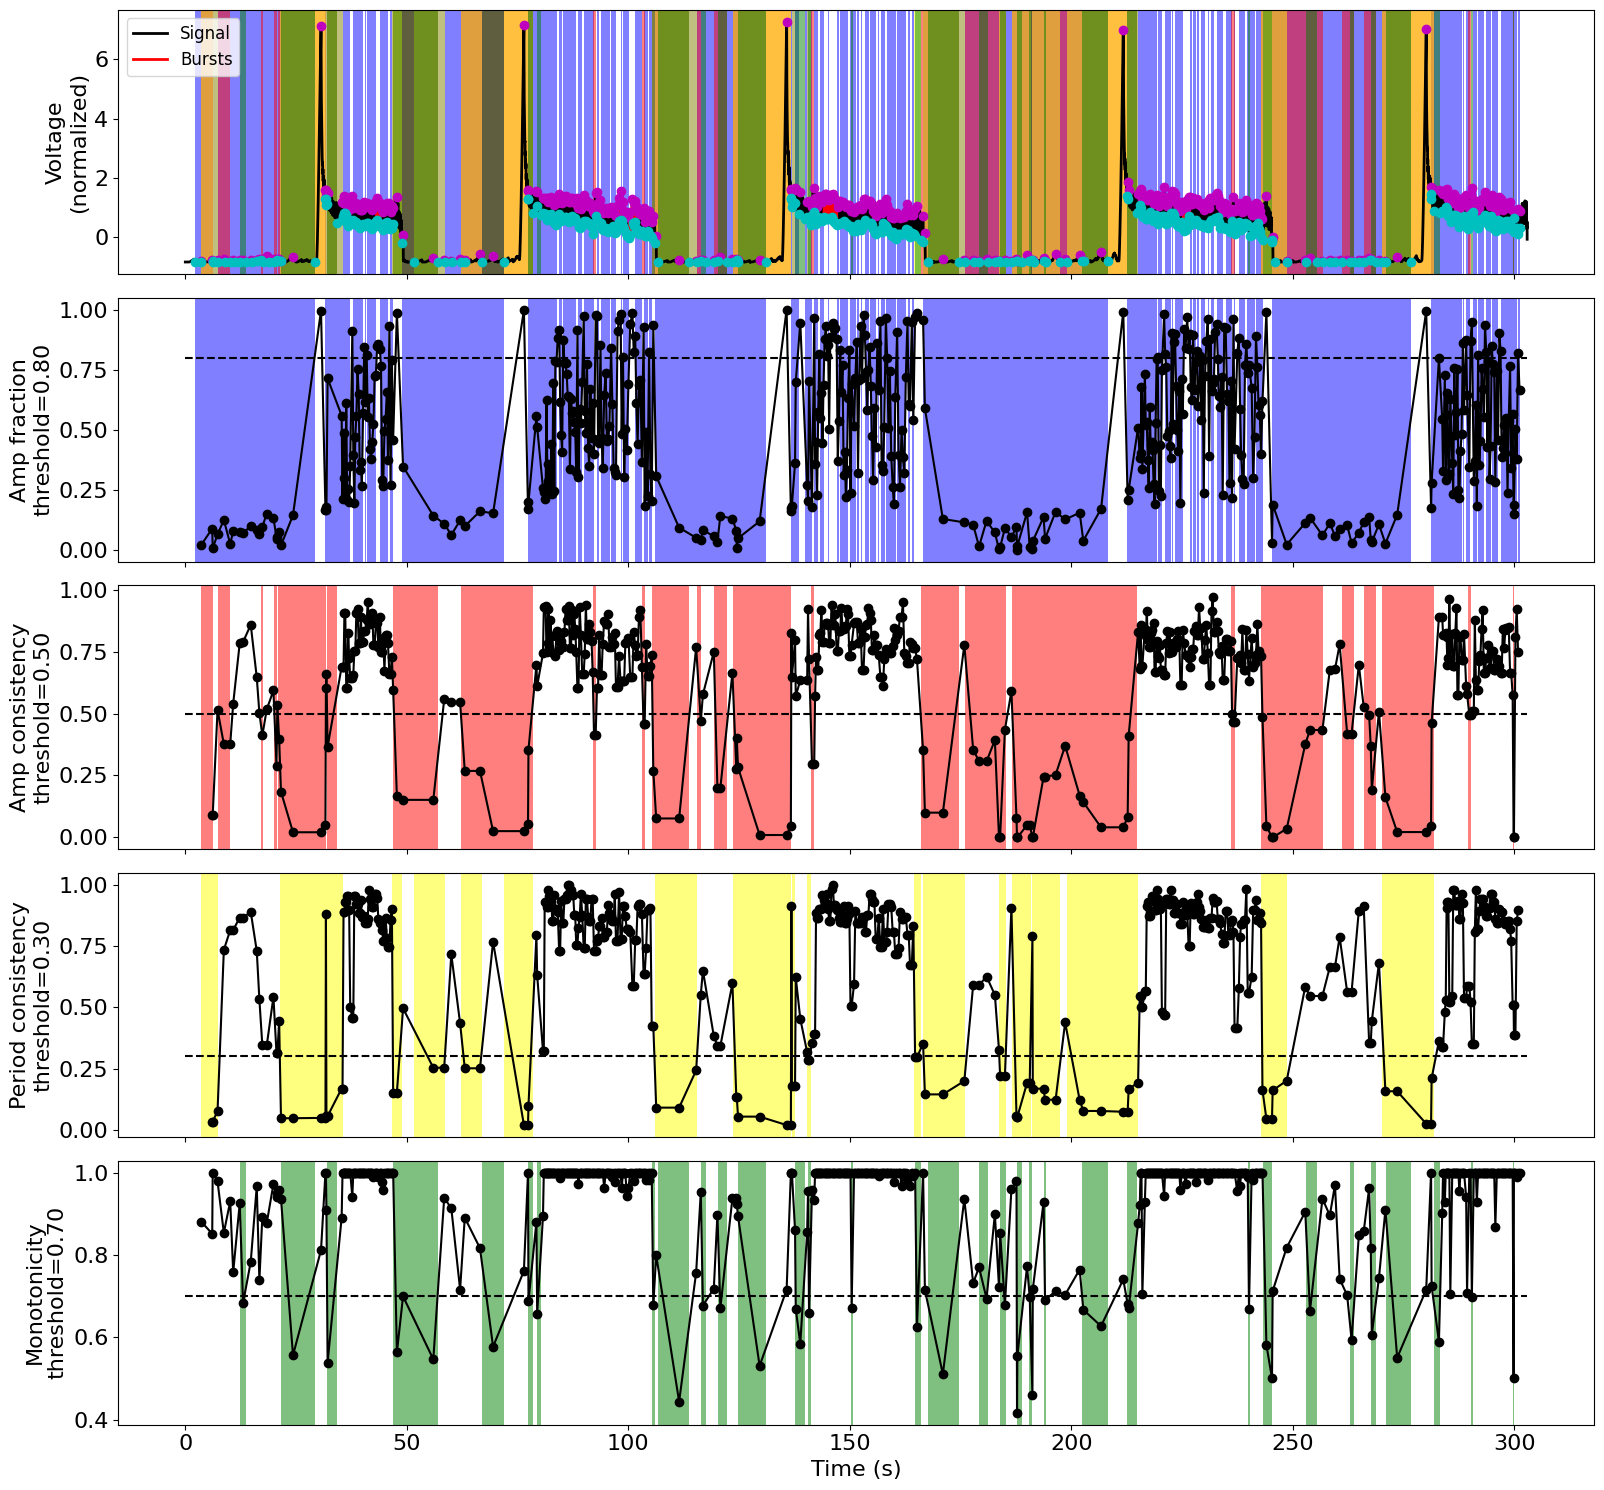

In [28]:
bm = Bycycle(thresholds=thresholds)
bm.fit(filt_5m, fs, f_range)
bm.plot(figsize=(16, 3))

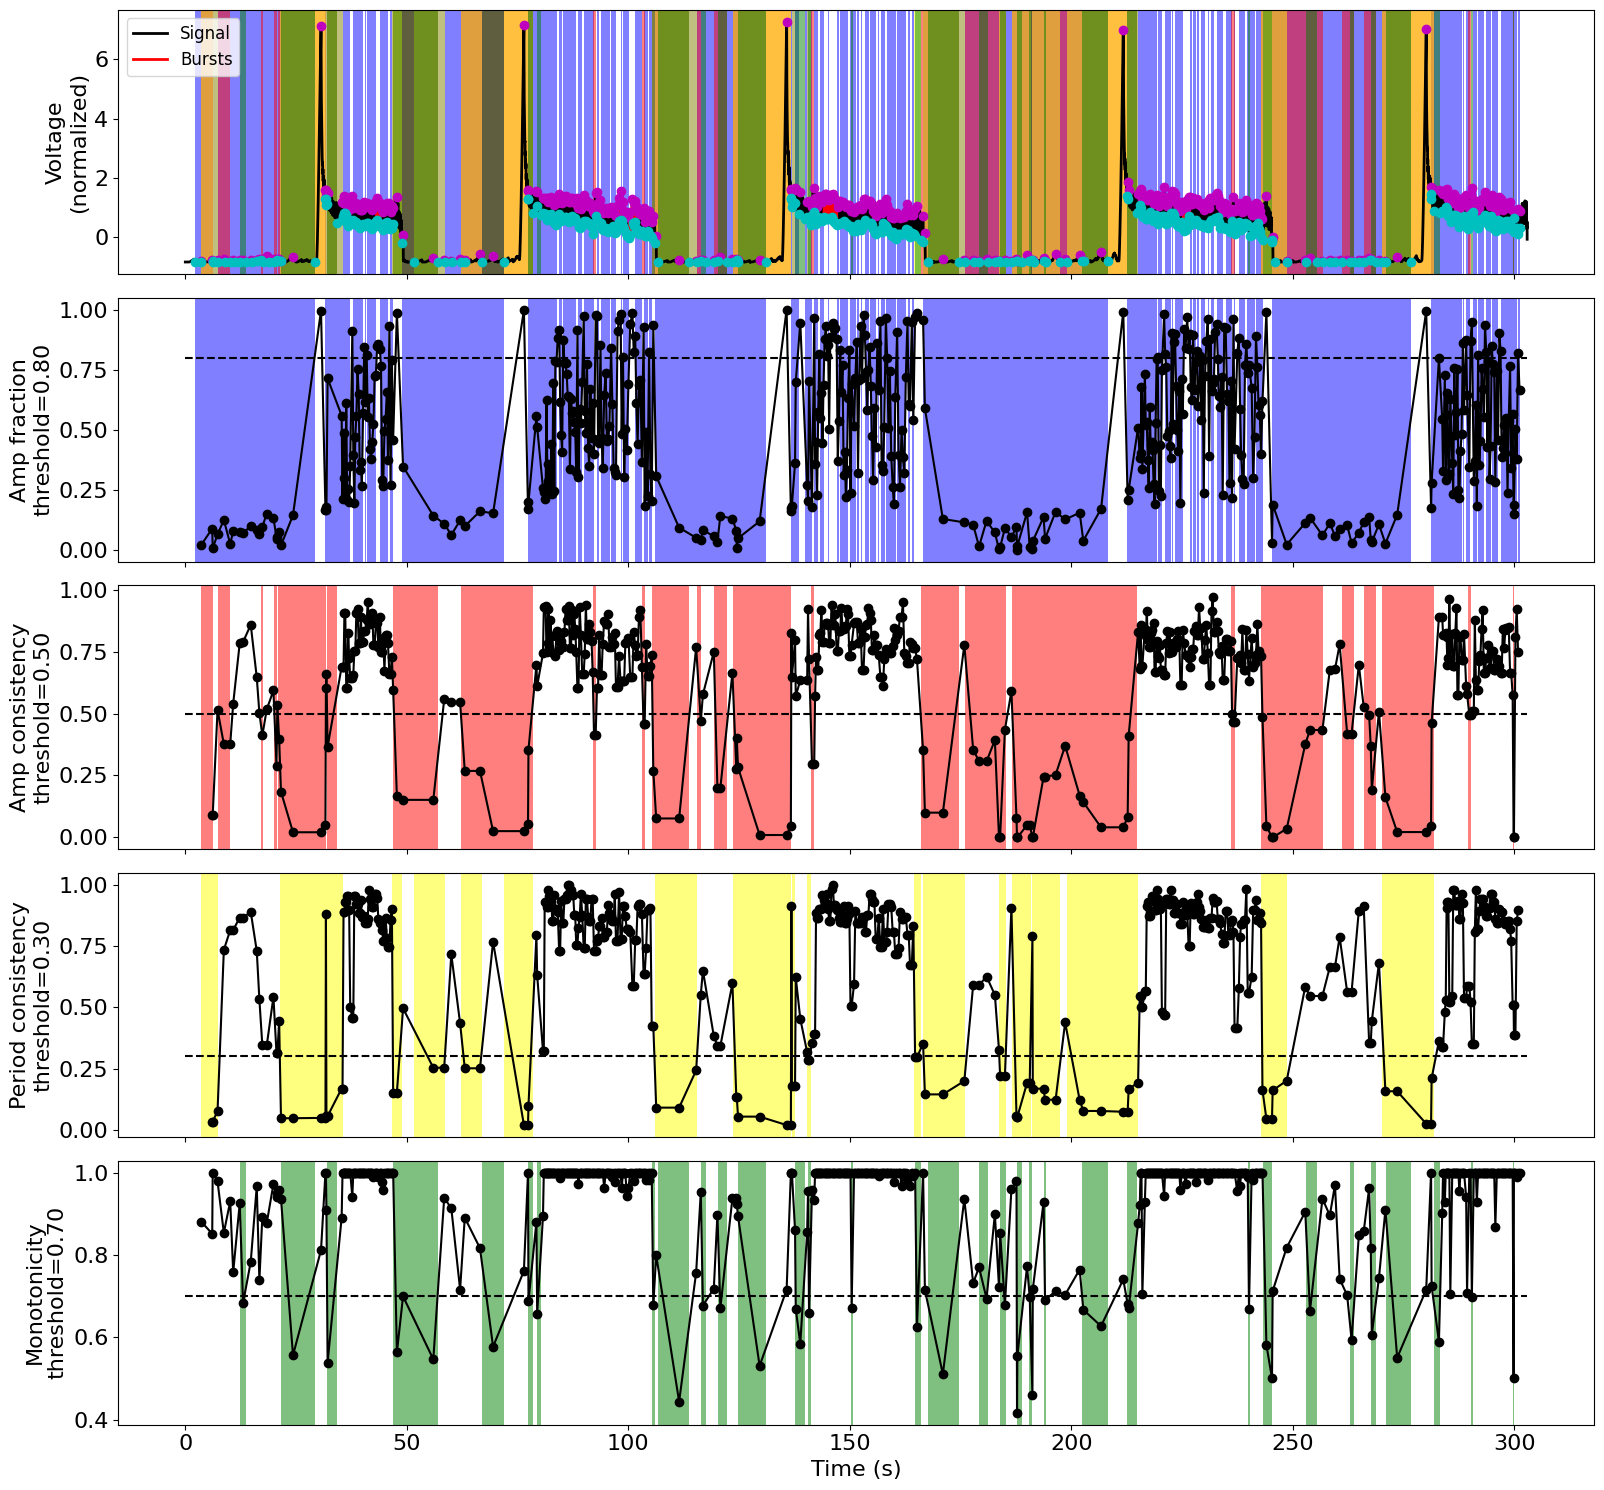

In [29]:
bm = Bycycle(thresholds=thresholds)
bm.fit(filt_5m, fs, f_range)
bm.plot(figsize=(16, 3))

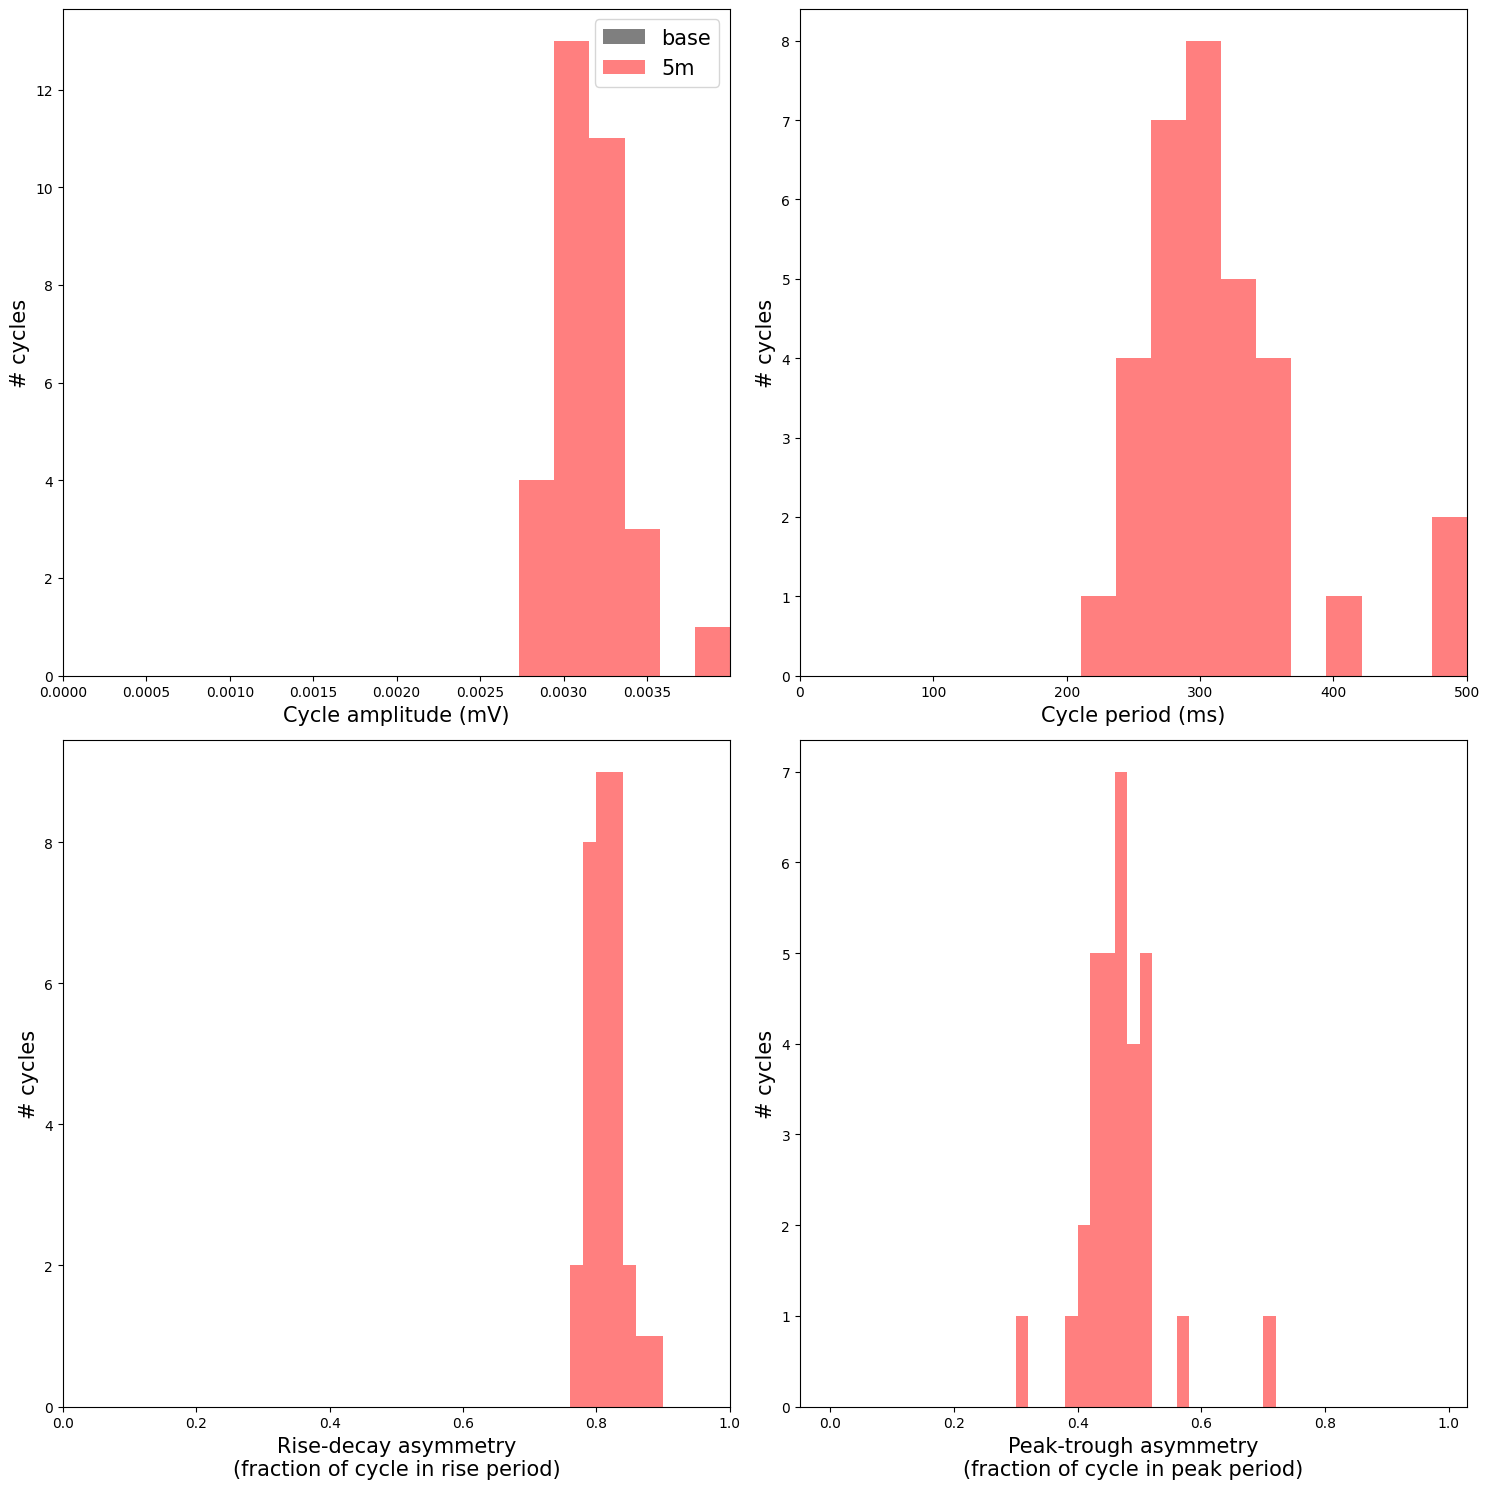

In [30]:
# Cycle-by-cycle analysis
# Ensure both signals have the same length for comparison, since they have different durations
min_len = min(filt_base.shape[0], filt_5m.shape[0])
sigs = np.vstack([filt_base[:min_len], filt_5m[:min_len]])

# Perform cycle-by-cycle analysis using BycycleGroup
bg = BycycleGroup(thresholds=thresholds, center_extrema='trough', return_samples=False)
bg.fit(sigs, fs, f_range)

# Extract features for baseline and 5-minute conditions
df_base, df_5m = bg.df_features

# Limit analysis only to oscillatory bursts
df_base_cycles = df_base[df_base['is_burst']]
df_5m_cycles = df_5m[df_5m['is_burst']]

# Create a 2x2 subplot for visualizations
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Plot cycle amplitude
cycles_base = df_base_cycles['volt_amp']
cycles_5m = df_5m_cycles['volt_amp']
max_amp = cycles_5m.max()
amp_bins = np.linspace(0, max_amp, 20)

plot_feature_hist(cycles_base, 'volt_amp', ax=axes[0][0], xlabel='Cycle amplitude (mV)',
                  xlim=(0, max_amp), color='k', bins=amp_bins)
plot_feature_hist(cycles_5m, 'volt_amp', ax=axes[0][0], xlabel='Cycle amplitude (mV)',
                  xlim=(0, max_amp), color='r', bins=amp_bins)
axes[0][0].legend(['base', '5m'], fontsize=15)

# Plot cycle period
periods_base = df_base_cycles['period'] / fs * 1000  # Convert to milliseconds
periods_5m = df_5m_cycles['period'] / fs * 1000  # Convert to milliseconds
max_period = periods_5m.max()
period_bins = np.linspace(0, max_period, 20)

plot_feature_hist(periods_base, 'period', ax=axes[0][1], xlabel='Cycle period (ms)',
                  xlim=(0, max_period), color='k', bins=period_bins)
plot_feature_hist(periods_5m, 'period', ax=axes[0][1], xlabel='Cycle period (ms)',
                  xlim=(0, max_period), color='r', bins=period_bins)

# Plot rise/decay symmetry
plot_feature_hist(df_base_cycles, 'time_rdsym', ax=axes[1][0], xlim=(0, 1), color='k',
                  xlabel='Rise-decay asymmetry\n(fraction of cycle in rise period)',
                  bins=np.arange(0, 1, .02))
plot_feature_hist(df_5m_cycles, 'time_rdsym', ax=axes[1][0], xlim=(0, 1), color='r',
                  xlabel='Rise-decay asymmetry\n(fraction of cycle in rise period)',
                  bins=np.arange(0, 1, .02))

# Plot peak/trough symmetry
plot_feature_hist(df_base_cycles, 'time_ptsym', ax=axes[1][1], color='k',
                  xlabel='Peak-trough asymmetry\n(fraction of cycle in peak period)',
                  bins=np.arange(0, 1, .02))
plot_feature_hist(df_5m_cycles, 'time_ptsym', ax=axes[1][1], color='r',
                  xlabel='Peak-trough asymmetry\n(fraction of cycle in peak period)',
                  bins=np.arange(0, 1, .02))

plt.tight_layout()
plt.show()